In [140]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
import pyproj

In [62]:
import matplotlib

In [87]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [111]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,gdp_per_cap
127,38482919.0,Europe,Poland,POL,667900.0,"POLYGON ((15.01699588385867 51.10667409932158,...",0.017356


C:\Users\opera_user\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


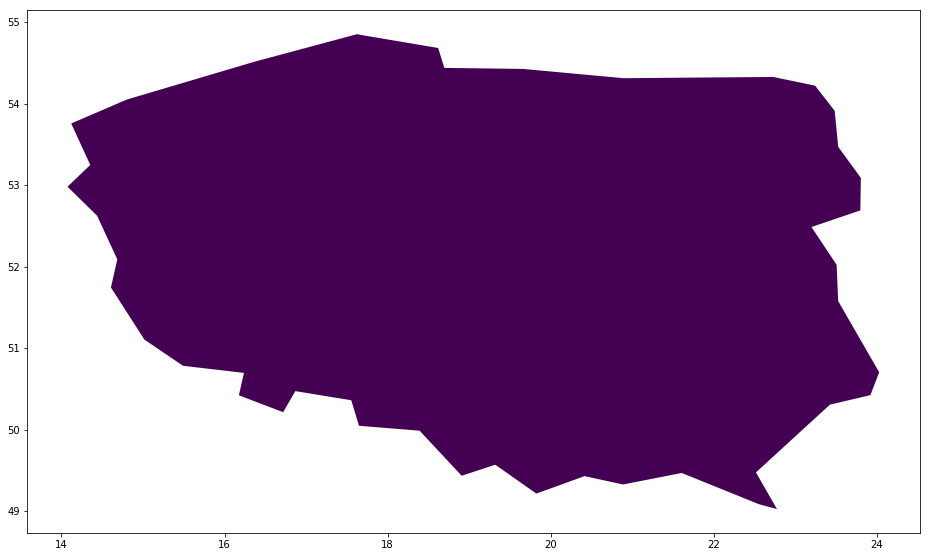

In [89]:
world = world[(world.pop_est>0) & (world.name=="Poland")]

world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

world.plot(column='gdp_per_cap')

plt.show()

# https://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.WsX2taOsZPZ

In [1]:
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

## Ogarnięcie pozycji niebieskich tabliczek do postaci ramki danych

In [2]:
tree = etree.parse("plaques_20140619.xml")
root = tree.getroot()

output = dict()
output['raw'] = []
output['crs'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('/openplaques/plaque/geo'):
    # check what we got back
    output['crs'].append(each.get('reference_system'))
    output['lon'].append(each.get('longitude'))
    output['lat'].append(each.get('latitude'))
    # now go back up to plaque
    r = each.getparent().xpath('inscription/raw')[0]
    if isinstance(r.text, str):
        output['raw'].append(r.text.lstrip().rstrip())
    else:
        output['raw'].append(None)

In [7]:
df = pd.DataFrame(output)
df = df.replace({'raw': 0}, None)
df = df.dropna()
df[['lon', 'lat']] = df[['lon', 'lat']].astype(float)

# ---------------------------------------

# Wczytywanie shp i robienie z tego mapy bazowej

In [101]:
sss1 = gpd.read_file('obreby_ewidencyjne.shp',encoding='windows-1250')

In [130]:
sss1.query("jpt_kod_je like '247301_1%'")

SyntaxError: invalid syntax (<unknown>, line 1)

In [131]:
sss1[sss1.jpt_kod_je.str.startswith('247301_1').fillna(False)]

,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,...,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry
39238,PL.PZGIK.200,b4987920-576a-48da-9ad9-c9eea653767b,2012-09-23T21:08:42+02:00,OBR,247301_1.0065,NIEWIADOM GÓRNY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583420,None,None,AKTUALNY,None,None,"POLYGON ((460066.442713937 246112.270816539, 4..."
39649,PL.PZGIK.200,588ac8c8-4343-436f-8fb1-81dc0dafef05,2012-09-23T21:08:42+02:00,OBR,247301_1.0063,NIEDOBCZYCE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583424,None,None,AKTUALNY,None,None,"POLYGON ((462016.762004825 243864.59960703, 46..."
39703,PL.PZGIK.200,ff48497f-774a-4c74-945a-b32aa8fe4467,2012-09-23T21:08:42+02:00,OBR,247301_1.0113,STODOŁY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583421,None,None,AKTUALNY,None,None,"POLYGON ((460736.56399596 254393.996812257, 46..."
39704,PL.PZGIK.200,2439b95a-2c09-4f93-8368-d7a5ab86f46f,2012-09-23T21:08:42+02:00,OBR,247301_1.0009,CHWAŁĘCICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583422,None,None,AKTUALNY,None,None,"POLYGON ((460811.60120831 250488.491013309, 46..."
39705,PL.PZGIK.200,fb974ebc-9f05-4e22-b344-e446e4d7568c,2012-09-23T21:08:42+02:00,OBR,247301_1.0064,NIEWIADOM DOLNY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583423,None,None,AKTUALNY,None,None,"POLYGON ((461760.106334717 245425.939509219, 4..."
39753,PL.PZGIK.200,4cdbff8d-6674-4376-b6d8-829a07b4bbeb,2012-09-23T21:08:42+02:00,OBR,247301_1.0102,ZEBRZYDOWICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583425,None,None,AKTUALNY,None,None,"POLYGON ((462787.479262692 247484.826487301, 4..."
39754,PL.PZGIK.200,f86d60cb-6ec2-4f00-8dfc-95e2cecaf880,2012-09-23T21:08:42+02:00,OBR,247301_1.0067,ORZEPOWICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583426,None,None,AKTUALNY,None,None,"POLYGON ((464097.755889713 250304.779269368, 4..."
39755,PL.PZGIK.200,5327fbab-399b-40f2-8ce6-aa21657ea246,2012-09-23T21:08:42+02:00,OBR,247301_1.0106,SMOLNA,None,None,NZN,0.0,...,0.0,12720.0,0.0,583427,None,None,AKTUALNY,None,None,"POLYGON ((464138.719430666 246515.811844801, 4..."
39756,PL.PZGIK.200,d9aa9b65-eb13-4a3b-a27d-d820e09eb031,2012-09-23T21:08:42+02:00,OBR,247301_1.0074,POPIELÓW,None,None,NZN,0.0,...,0.0,12720.0,0.0,583428,None,None,AKTUALNY,None,None,"POLYGON ((464158.977112341 243171.845158629, 4..."
39757,PL.PZGIK.200,1368c2e9-ba1a-4332-9d2a-c0a06384ff91,2012-09-23T21:08:42+02:00,OBR,247301_1.0125,ZAMYSŁÓW,None,None,NZN,0.0,...,0.0,12720.0,0.0,583429,None,None,AKTUALNY,None,None,"POLYGON ((464402.864416492 246124.302801652, 4..."


In [123]:
sss1.query("jpt_nazwa_ == 'RYBNIK'").iloc[2:,:]

,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,...,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry
39758,PL.PZGIK.200,8920427d-2ae7-44df-a025-f15de9e2c560,2012-09-23T21:08:42+02:00,OBR,247301_1.0089,RYBNIK,None,None,NZN,0.0,...,0.0,12720.0,0.0,583430,None,None,AKTUALNY,None,None,"POLYGON ((464457.221039299 248300.762223668, 4..."


In [160]:
abc = sss1[sss1.jpt_kod_je.str.startswith('247301_1').fillna(False)]

In [164]:
rybnik = abc.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [166]:
rybnik

,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,...,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry
39238,PL.PZGIK.200,b4987920-576a-48da-9ad9-c9eea653767b,2012-09-23T21:08:42+02:00,OBR,247301_1.0065,NIEWIADOM GÓRNY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583420,None,None,AKTUALNY,None,None,"POLYGON ((18.44168423057649 50.08092161457218,..."
39649,PL.PZGIK.200,588ac8c8-4343-436f-8fb1-81dc0dafef05,2012-09-23T21:08:42+02:00,OBR,247301_1.0063,NIEDOBCZYCE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583424,None,None,AKTUALNY,None,None,"POLYGON ((18.46917385728835 50.06082891680376,..."
39703,PL.PZGIK.200,ff48497f-774a-4c74-945a-b32aa8fe4467,2012-09-23T21:08:42+02:00,OBR,247301_1.0113,STODOŁY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583421,None,None,AKTUALNY,None,None,"POLYGON ((18.45020022317899 50.15546998671915,..."
39704,PL.PZGIK.200,2439b95a-2c09-4f93-8368-d7a5ab86f46f,2012-09-23T21:08:42+02:00,OBR,247301_1.0009,CHWAŁĘCICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583422,None,None,AKTUALNY,None,None,"POLYGON ((18.45165264899881 50.12034053325178,..."
39705,PL.PZGIK.200,fb974ebc-9f05-4e22-b344-e446e4d7568c,2012-09-23T21:08:42+02:00,OBR,247301_1.0064,NIEWIADOM DOLNY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583423,None,None,AKTUALNY,None,None,"POLYGON ((18.46543108401609 50.07485867295662,..."
39753,PL.PZGIK.200,4cdbff8d-6674-4376-b6d8-829a07b4bbeb,2012-09-23T21:08:42+02:00,OBR,247301_1.0102,ZEBRZYDOWICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583425,None,None,AKTUALNY,None,None,"POLYGON ((18.47959195148671 50.09344618104714,..."
39754,PL.PZGIK.200,f86d60cb-6ec2-4f00-8dfc-95e2cecaf880,2012-09-23T21:08:42+02:00,OBR,247301_1.0067,ORZEPOWICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583426,None,None,AKTUALNY,None,None,"POLYGON ((18.49764981304466 50.11889584386341,..."
39755,PL.PZGIK.200,5327fbab-399b-40f2-8ce6-aa21657ea246,2012-09-23T21:08:42+02:00,OBR,247301_1.0106,SMOLNA,None,None,NZN,0.0,...,0.0,12720.0,0.0,583427,None,None,AKTUALNY,None,None,"POLYGON ((18.49857890101274 50.08481182452786,..."
39756,PL.PZGIK.200,d9aa9b65-eb13-4a3b-a27d-d820e09eb031,2012-09-23T21:08:42+02:00,OBR,247301_1.0074,POPIELÓW,None,None,NZN,0.0,...,0.0,12720.0,0.0,583428,None,None,AKTUALNY,None,None,"POLYGON ((18.49917553255076 50.05472971789253,..."
39757,PL.PZGIK.200,1368c2e9-ba1a-4332-9d2a-c0a06384ff91,2012-09-23T21:08:42+02:00,OBR,247301_1.0125,ZAMYSŁÓW,None,None,NZN,0.0,...,0.0,12720.0,0.0,583429,None,None,AKTUALNY,None,None,"POLYGON ((18.50230856151642 50.08130559012709,..."


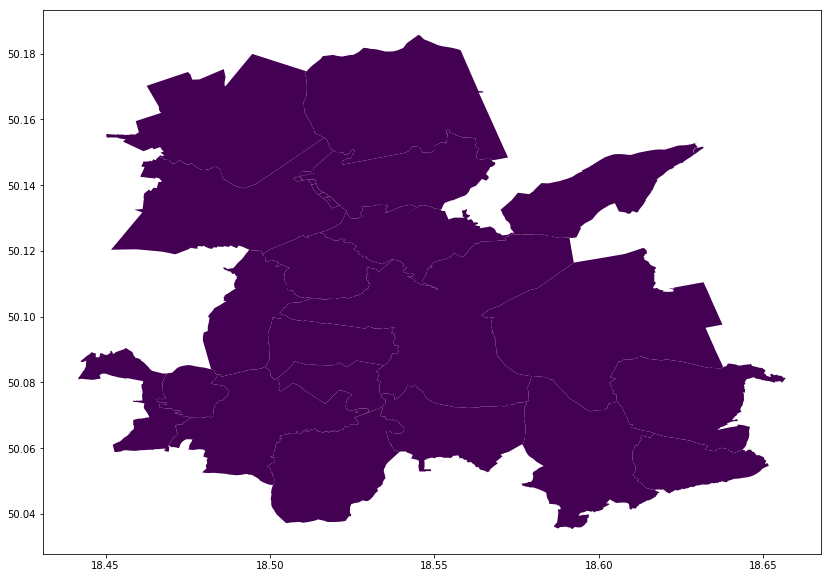

In [167]:
rybnik.plot(column='id_bufora_')
plt.show()

In [175]:
rybnik.to_file('rybnik.shp', driver='ESRI Shapefile')

In [148]:
from pyproj import Proj, transform

In [194]:
shp = fiona.open('rybnik.shp',encoding='windows-1250')
bds = shp.bounds
shp.close()
extra = 0.01
#cs92 = pyproj.Proj("+init=EPSG:2180")
#wgs84 = pyproj.Proj("+init=EPSG:4326")
ll = (bds[0], bds[1])
ur = (bds[2], bds[3]) 
#ll = pyproj.transform(cs92, wgs84, bds[0], bds[1])
#ur = pyproj.transform(cs92, wgs84, bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [195]:
ll, ur

((18.44168423057649, 50.03540818733495),
 (18.656839587997112, 50.18567083284379))

In [196]:
m = Basemap(
    projection='tmerc',
    lon_0=18.44,
    lat_0=50.18,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

In [203]:
m.readshapefile(
    'rybnik',
    'obszary',
    color='none',
    default_encoding='windows-1250',
    zorder=2)

(20,
 5,
 [18.44168423057649, 50.03540818733495, 0.0, 0.0],
 [18.656839587997112, 50.18567083284379, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x2c8796d8>)

In [200]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.dzielnice],
    'ward_name': [ward['jpt_nazwa_'] for ward in m.dzielnice_info]})
#df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
#df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['lon'], df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

In [205]:
rybnik

,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,...,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry
39238,PL.PZGIK.200,b4987920-576a-48da-9ad9-c9eea653767b,2012-09-23T21:08:42+02:00,OBR,247301_1.0065,NIEWIADOM GÓRNY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583420,None,None,AKTUALNY,None,None,"POLYGON ((18.44168423057649 50.08092161457218,..."
39649,PL.PZGIK.200,588ac8c8-4343-436f-8fb1-81dc0dafef05,2012-09-23T21:08:42+02:00,OBR,247301_1.0063,NIEDOBCZYCE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583424,None,None,AKTUALNY,None,None,"POLYGON ((18.46917385728835 50.06082891680376,..."
39703,PL.PZGIK.200,ff48497f-774a-4c74-945a-b32aa8fe4467,2012-09-23T21:08:42+02:00,OBR,247301_1.0113,STODOŁY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583421,None,None,AKTUALNY,None,None,"POLYGON ((18.45020022317899 50.15546998671915,..."
39704,PL.PZGIK.200,2439b95a-2c09-4f93-8368-d7a5ab86f46f,2012-09-23T21:08:42+02:00,OBR,247301_1.0009,CHWAŁĘCICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583422,None,None,AKTUALNY,None,None,"POLYGON ((18.45165264899881 50.12034053325178,..."
39705,PL.PZGIK.200,fb974ebc-9f05-4e22-b344-e446e4d7568c,2012-09-23T21:08:42+02:00,OBR,247301_1.0064,NIEWIADOM DOLNY,None,None,NZN,0.0,...,0.0,12720.0,0.0,583423,None,None,AKTUALNY,None,None,"POLYGON ((18.46543108401609 50.07485867295662,..."
39753,PL.PZGIK.200,4cdbff8d-6674-4376-b6d8-829a07b4bbeb,2012-09-23T21:08:42+02:00,OBR,247301_1.0102,ZEBRZYDOWICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583425,None,None,AKTUALNY,None,None,"POLYGON ((18.47959195148671 50.09344618104714,..."
39754,PL.PZGIK.200,f86d60cb-6ec2-4f00-8dfc-95e2cecaf880,2012-09-23T21:08:42+02:00,OBR,247301_1.0067,ORZEPOWICE,None,None,NZN,0.0,...,0.0,12720.0,0.0,583426,None,None,AKTUALNY,None,None,"POLYGON ((18.49764981304466 50.11889584386341,..."
39755,PL.PZGIK.200,5327fbab-399b-40f2-8ce6-aa21657ea246,2012-09-23T21:08:42+02:00,OBR,247301_1.0106,SMOLNA,None,None,NZN,0.0,...,0.0,12720.0,0.0,583427,None,None,AKTUALNY,None,None,"POLYGON ((18.49857890101274 50.08481182452786,..."
39756,PL.PZGIK.200,d9aa9b65-eb13-4a3b-a27d-d820e09eb031,2012-09-23T21:08:42+02:00,OBR,247301_1.0074,POPIELÓW,None,None,NZN,0.0,...,0.0,12720.0,0.0,583428,None,None,AKTUALNY,None,None,"POLYGON ((18.49917553255076 50.05472971789253,..."
39757,PL.PZGIK.200,1368c2e9-ba1a-4332-9d2a-c0a06384ff91,2012-09-23T21:08:42+02:00,OBR,247301_1.0125,ZAMYSŁÓW,None,None,NZN,0.0,...,0.0,12720.0,0.0,583429,None,None,AKTUALNY,None,None,"POLYGON ((18.50230856151642 50.08130559012709,..."


In [201]:
df_map

,poly,ward_name
0,"POLYGON ((154.0357452796768 6007.628186112856,...",NIEWIADOM G�RNY
1,"POLYGON ((2122.487761958129 3773.11519527772, ...",NIEDOBCZYCE
2,"POLYGON ((762.4380050697113 14299.79206449782,...",STODO?Y
3,"POLYGON ((866.8445764050664 10392.29771663352,...",CHWA??CICE
4,"POLYGON ((4822.182343717076 12810.30952112451,...",CHWA??CICE
5,"POLYGON ((5131.555237050373 12755.79159226298,...",CHWA??CICE
6,"POLYGON ((5223.502351655712 12592.9168548499, ...",CHWA??CICE
7,"POLYGON ((5381.95795339942 12264.33717142857, ...",CHWA??CICE
8,"POLYGON ((5484.301634064977 12131.27354769171,...",CHWA??CICE
9,"POLYGON ((1853.954413273704 5333.552237605649,...",NIEWIADOM DOLNY


In [40]:
shp = fiona.open('london_wards.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [42]:
w, h

(0.8443906332745678, 0.4051139537590416)

In [43]:
print(coords[0], coords[1], coords[2] ,coords[3])

(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)


In [44]:
w, h

(0.8443906332745678, 0.4051139537590416)

In [45]:
m = Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'london_wards',
    'london',
    color='none',
    zorder=2)

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x29c3ae80>)

# Postać ramki danych z dzielnicami i wielkościami

In [47]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_name': [ward['NAME'] for ward in m.london_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['lon'], df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

In [170]:
df_map

,poly,ward_name,area_m,area_km,count,density_m,density_km,jenks_bins,patches
0,"POLYGON ((13004.06946679378 5643.556704930117,...",Chessington South Ward,7.557384e+06,75.573841,0,NaN,NaN,-1.0,"Poly((13004.1, 5643.56) ...)"
1,"POLYGON ((14432.57909461123 10890.80719812433,...",Tolworth and Hook Rise Ward,2.596590e+06,25.965904,1,3.851204e-07,0.038512,0.0,"Poly((14432.6, 10890.8) ...)"
2,"POLYGON ((14710.57509348575 12747.79659884246,...",Berrylands Ward,1.454965e+06,14.549655,0,NaN,NaN,-1.0,"Poly((14710.6, 12747.8) ...)"
3,"POLYGON ((17083.95639115885 12354.059671809, 1...",Alexandra Ward,2.687010e+06,26.870103,0,NaN,NaN,-1.0,"Poly((17084, 12354.1) ...)"
4,"POLYGON ((18675.54168399898 13589.62372055175,...",Beverley Ward,1.879597e+06,18.795975,0,NaN,NaN,-1.0,"Poly((18675.5, 13589.6) ...)"
5,"POLYGON ((18612.11378584465 14742.45080214852,...",Coombe Hill Ward,4.424962e+06,44.249620,4,9.039626e-07,0.090396,0.0,"Poly((18612.1, 14742.5) ...)"
6,"POLYGON ((13778.04166202739 9520.496764869342,...",Chessington North and Hook Ward,1.931236e+06,19.312361,0,NaN,NaN,-1.0,"Poly((13778, 9520.5) ...)"
7,"POLYGON ((14072.14004289791 12322.73661365363,...",Surbiton Hill Ward,1.666071e+06,16.660709,0,NaN,NaN,-1.0,"Poly((14072.1, 12322.7) ...)"
8,"POLYGON ((18835.70916394518 11458.93453373257,...",Old Malden Ward,1.801488e+06,18.014876,0,NaN,NaN,-1.0,"Poly((18835.7, 11458.9) ...)"
9,"POLYGON ((14063.43330370706 13247.47936071208,...",St. Mark's Ward,1.376784e+06,13.767837,1,7.263305e-07,0.072633,0.0,"Poly((14063.4, 13247.5) ...)"


In [53]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [54]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

In [55]:
df_map.head()

,poly,ward_name,area_m,area_km,count,density_m,density_km
0,"POLYGON ((13004.06946679378 5643.556704930117,...",Chessington South Ward,7.557384e+06,75.573841,0,NaN,NaN
1,"POLYGON ((14432.57909461123 10890.80719812433,...",Tolworth and Hook Rise Ward,2.596590e+06,25.965904,1,3.851204e-07,0.038512
2,"POLYGON ((14710.57509348575 12747.79659884246,...",Berrylands Ward,1.454965e+06,14.549655,0,NaN,NaN
3,"POLYGON ((17083.95639115885 12354.059671809, 1...",Alexandra Ward,2.687010e+06,26.870103,0,NaN,NaN
4,"POLYGON ((18675.54168399898 13589.62372055175,...",Beverley Ward,1.879597e+06,18.795975,0,NaN,NaN


In [56]:
# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

In [57]:
jenks_labels = ["<= %0.1f/km$^2$(%s wards)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))

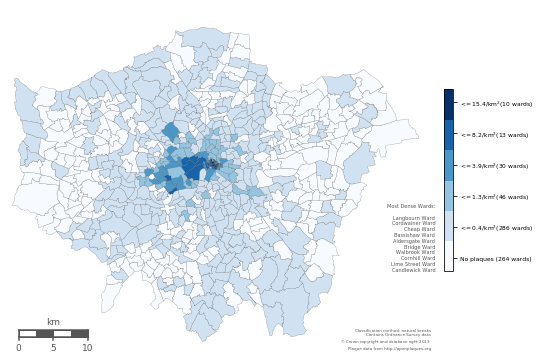

In [67]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=6)

# Show highest densities, in descending order
highest = '\n'.join(
    value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort_index().iterrows())
highest = 'Most Dense Wards:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    -1., 0 - 0.007,
    highest,
    ha='right', va='bottom',
    size=5,
    color='#555555')

# Bin method, copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Classification method: natural breaks\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org',
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.savefig('london_plaques.png', dpi=100, alpha=True)
plt.show()